In [0]:
import sys, os, shutil
from glob import glob
import numpy as np

## Change Runtime on Colab

## Get Data

In [0]:
!mkdir -p data/redux/

In [4]:
# Download in correct directory
!kg download -u skakki -p akshaykumar -c dogs-vs-cats-redux-kernels-edition

downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/test.zip

test.zip 100% |######################################| Time: 0:00:06  41.9 MiB/s

downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip

train.zip 100% |#####################################| Time: 0:00:13  39.7 MiB/s

downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/sample_submission.csv

sample_submission.csv 100% |#########################| Time: 0:00:00 485.7 KiB/s



In [0]:
!unzip test.zip -d data/redux/
!unzip train.zip -d data/redux/

In [0]:
# Create new directories if required

!mkdir data/redux/test/unknown/
!mkdir data/redux/train/cats
!mkdir data/redux/train/dogs
!mkdir -p data/redux/valid/cats
!mkdir -p data/redux/valid/dogs
!mkdir -p data/redux/results
!mkdir -p data/redux/sample/train/cats
!mkdir -p data/redux/sample/train/dogs
!mkdir -p data/redux/sample/valid/cats
!mkdir -p data/redux/sample/valid/dogs
!mkdir -p data/redux/sample/test/unknown
!mkdir -p data/redux/sample/results

In [0]:
# these paths are when you are at home directory

path = 'data/redux/'
# path = 'data/redux/sample/'

train_path = path+'train/'
val_path = path+'valid/'
test_path = path+'test/'
sample_path = path+'sample/'
results_path = path+'results/'

In [0]:
# copy 800 images from train and 400 from test to sample
g = glob(train_path+'*.jpg')
g = np.random.permutation(g)
for i in range(800):
  shutil.copy(g[i], sample_path+'train/')

g = glob(test_path+'*.jpg')
g = np.random.permutation(g)
for i in range(400):
  shutil.copy(g[i], sample_path+'test/')

# Move 75 images from sample/train to sample/valid
g = glob(sample_path+'train/*.jpg')
g = np.random.permutation(g)
for i in range(75):
  shutil.copy(g[i], sample_path+'valid/')


# move 2000 images from train to valid directory

g = glob(train_path+'*.jpg')
g = np.random.permutation(g)
for i in range(2000):
  shutil.move(g[i], val_path)



In [0]:
# move image in corresponsing label directories

!mv sample_submission.csv data/redux/

!mv data/redux/test/*.jpg data/redux/test/unknown/
!mv data/redux/train/cat*.jpg data/redux/train/cats/
!mv data/redux/train/dog*.jpg data/redux/train/dogs/
!mv data/redux/valid/dog*.jpg data/redux/valid/dogs/
!mv data/redux/valid/cat*.jpg data/redux/valid/cats/

!mv data/redux/sample/valid/cat*.jpg data/redux/sample/valid/cats/
!mv data/redux/sample/valid/dog*.jpg data/redux/sample/valid/dogs/
!mv data/redux/sample/train/cat*.jpg data/redux/sample/train/cats/
!mv data/redux/sample/train/dog*.jpg data/redux/sample/train/dogs/
!mv data/redux/sample/test/*.jpg data/redux/sample/test/unknown/


In [12]:
!tree data/ -d

data/
└── redux
    ├── sample
    │   ├── test
    │   │   └── unknown
    │   ├── train
    │   │   ├── cats
    │   │   └── dogs
    │   └── valid
    │       ├── cats
    │       └── dogs
    ├── test
    │   └── unknown
    ├── train
    │   ├── cats
    │   └── dogs
    └── valid
        ├── cats
        └── dogs

18 directories


## Install Packages

Following packages need to installed everytime. Also first change directory to the location where this notebook is located. 

In [0]:
!pip install tqdm
!pip install bcolz
!pip install theano

In [0]:
# libgpu installation 
! git clone https://github.com/Theano/libgpuarray.git
!mkdir -p libgpuarray/Build/
os.chdir('libgpuarray/Build')

!apt-get install -y cmake
! cmake .. -DCMAKE_BUILD_TYPE=Release
! make
! make install

! pip install --upgrade cython
os.chdir('../')
!python setup.py build
!python setup.py install
os.chdir('../')


In [0]:
!pip install keras==1.2

## Utility functions

In [0]:
def chdir_home():
  pwd = !pwd
  if pwd[0].count('/') > 1 : 
    os.chdir((pwd[0].count('/')-1)*'../')

Now that we have organised our data lets finetune VGG16 model. 

## Finetune using VGG

In [0]:
# change directory so that python can find utils and other files
chdir_home()
os.chdir('drive/workspace/Dogs-Cats-Redux/')

In [0]:
%matplotlib inline
import sys, os, shutil
from glob import glob
import numpy as np
# from utils import *
# from vgg16 import Vgg16
from PIL import Image
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from IPython.display import FileLink

In [0]:
batch_size=64
no_epochs=2

chdir_home()
# path = 'data/redux/'
path = 'data/redux/sample/'

train_path = path+'train/'
val_path = path+'valid/'
test_path = path+'test/'
results_path = path+'results/'

In [65]:
vgg = Vgg16()
train_batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(val_path, batch_size=batch_size)
vgg.finetune(train_batches)

Found 800 images belonging to 2 classes.
Found 75 images belonging to 2 classes.


In [66]:
latest_weights_filename = None
for epoch in range(no_epochs):
    print ("\nRunning Epoch :  {0}".format(epoch))
    vgg.fit(train_batches, val_batches, nb_epoch=1)
    latest_weights_filename = "ft{0}.h5".format(epoch)
    vgg.model.save_weights(results_path+latest_weights_filename)
print ("Completed {0} fit operation\n".format(no_epochs))


Running Epoch :  0
Epoch 1/1
800/800 [==============================] - 17s - loss: 0.8919 - acc: 0.6938 - val_loss: 0.2141 - val_acc: 0.9067

Running Epoch :  1
Epoch 1/1
800/800 [==============================] - 16s - loss: 0.4825 - acc: 0.8525 - val_loss: 0.2267 - val_acc: 0.8800
Completed 2 fit operation



In [0]:
for epoch in range(no_epochs):
    print ("Epoch {0}".format(epoch))
    vgg.model.load_weights(filepath=results_path+'ft{0}.h5'.format(epoch))
    test_batches, test_preds = vgg.test(test_path, batch_size=batch_size)
    isdog = test_preds[:,1]
    isdog = isdog.clip(min=0.05, max=0.95)
    test_filenames = test_batches.filenames
    test_file_ids = [int(f[8:-4]) for f in test_filenames]
    subm = np.stack([test_file_ids, isdog], axis=1)
    subm_filename = "submission{0}.csv".format(epoch)
    np.savetxt(subm_filename, subm, fmt='%d,%0.5f', header='id,label', comments='')

Epoch 0
Found 12500 images belonging to 1 classes.
Epoch 1
Found 12500 images belonging to 1 classes.
Epoch 2
Found 12500 images belonging to 1 classes.


In [0]:
FileLink('submission3.csv')

/home/akshay/workspace/redux/submission3.csv

# Finetune from Scratch

In [0]:
# I have commented out import utils i above section so that we can manually import packages here. 
chdir_home()
os.chdir('drive/workspace/Dogs-Cats-Redux/')

from vgg16 import Vgg16
from utils import *
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.optimizers import RMSprop

import bcolz
from sklearn.preprocessing import OneHotEncoder
chdir_home()

In [0]:
# path = 'data/redux/'
path = 'data/redux/sample/'

train_path = path+'train/'
val_path = path+'valid/'
test_path = path+'test/'
results_path = path+'results/'
model_path = path+'models/'
if not os.path.exists(model_path): os.mkdir(model_path)


In [0]:
vgg = Vgg16()
model = vgg.model

In [86]:
val_batches = get_batches(val_path, batch_size=batch_size, shuffle=False)
train_batches = get_batches(train_path, batch_size=batch_size, shuffle=False)

Found 75 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [0]:
def save_array(fname, crr): 
  c=bcolz.carray(crr, rootdir=fname, mode='w')
  c.flush()
  
def load_array(fname):
  return bcolz.open(fname)


def OneHotEncoder(arr):
  

In [89]:
train_data = get_data(train_path)
val_data = get_data(val_path)
save_array(model_path+'train_data.bc', train_data)
save_array(model_path+'val_data.bc', val_data)

Found 800 images belonging to 2 classes.
Found 75 images belonging to 2 classes.


In [0]:
train_data = load_array(model_path+'train_data.bc')
val_data = load_array(model_path+'val_data.bc')

In [0]:
train_classes = train_batches.classes
val_classes = val_batches.classes
train_labels = to_categorical(train_classes, train_batches.nb_class)
val_labels = to_categorical(val_classes, val_batches.nb_class)

In [109]:
train_feat = model.predict(train_data, batch_size=batch_size, verbose=1)
val_feat = model.predict(val_data, batch_size=batch_size)

800/800 [==============================] - 14s    


In [0]:
save_array(model_path+'train_feat.bc', train_feat)
save_array(model_path+'val_feat.bc', val_feat)

In [0]:
train_feat = load_array(model_path+'train_feat.bc')
val_feat = load_array(model_path+'val_feat.bc')


Now let's define a linear model to append to vgg16. 

In [0]:
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# Here you can experiment with batch size
batch_size=64

In [119]:
lm.fit(train_feat, train_labels, nb_epoch=10, validation_data=(val_feat, val_labels), batch_size=batch_size)

Train on 800 samples, validate on 75 samples
Epoch 1/10
800/800 [==============================] - 0s - loss: 0.2908 - acc: 0.8938 - val_loss: 0.2262 - val_acc: 0.9200
Epoch 2/10
800/800 [==============================] - 0s - loss: 0.2639 - acc: 0.9050 - val_loss: 0.2012 - val_acc: 0.9333
Epoch 3/10
800/800 [==============================] - 0s - loss: 0.2421 - acc: 0.9037 - val_loss: 0.1807 - val_acc: 0.9733
Epoch 4/10
800/800 [==============================] - 0s - loss: 0.2251 - acc: 0.9225 - val_loss: 0.1854 - val_acc: 0.9200
Epoch 5/10
800/800 [==============================] - 0s - loss: 0.2126 - acc: 0.9200 - val_loss: 0.1580 - val_acc: 0.9733
Epoch 6/10
800/800 [==============================] - 0s - loss: 0.1992 - acc: 0.9337 - val_loss: 0.1462 - val_acc: 0.9733
Epoch 7/10
800/800 [==============================] - 0s - loss: 0.1921 - acc: 0.9325 - val_loss: 0.1491 - val_acc: 0.9733
Epoch 8/10
800/800 [==============================] - 0s - loss: 0.1837 - acc: 0.9337 - val_lo

In [120]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_28 (Dense)                 (None, 2)             2002        dense_input_2[0][0]              
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
____________________________________________________________________________________________________


### Viewing Predictions


In [126]:
preds = lm.predict_classes(val_feat, batch_size)
probs = lm.predict_proba(val_feat, batch_size)[:,0]

64/75 [========================>.....] - ETA: 0s

In [127]:
probs[:5]

array([0.8675, 0.9719, 0.9832, 0.5997, 0.9559], dtype=float32)

In [0]:
filenames = val_batches.filenames
n_view=4

In [0]:
def plot_idx(idx, titles=None):
  plots([Image.open(val_path+filenames[i]) for i in idx], titles=titles)

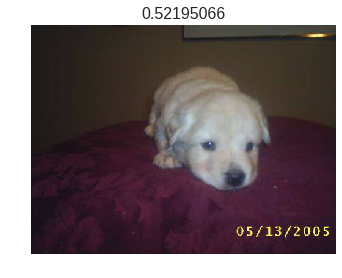

In [155]:
#  A few correct labesl at random

correct = np.where(preds!=val_labels[:,1])[0]
idx = np.random.permutation(correct)[:n_view]
plot_idx(idx, titles=probs[idx])